In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
!unzip '/content/archive.zip'

Archive:  /content/archive.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install twython
!pip install nltk

In [4]:
!pip install emoji

In [5]:
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties


# data processing
import re, string #Regular expressions
import emoji

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from wordcloud import WordCloud #Word visualization
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
from sklearn.model_selection import train_test_split #Data testing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from transformers import BertTokenizerFast
from transformers import AutoModel

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 640x480 with 0 Axes>

In [14]:
train_data = pd.read_csv("/content/twitter_training.csv", header = None, names = ["tweetid","entity","sentiment","content"])
valid_data = pd.read_csv("/content/twitter_validation.csv",header = None, names = ["tweetid","entity","sentiment","content"])

In [15]:
df = pd.concat([train_data, valid_data])
df

,tweetid,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [16]:
df.isnull().sum()

tweetid        0
entity         0
sentiment      0
content      686
dtype: int64

In [17]:
df.dropna(inplace=True)
df.isnull().sum()

tweetid      0
entity       0
sentiment    0
content      0
dtype: int64

In [18]:
# Kiểm tra mẫu dữ liệu trùng nhau và xóa chúng
df.duplicated().sum()

2857

In [19]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [20]:
# Loại bỏ các mẫu dữ liệu có sentiment là irrelevant
df = df[df.sentiment != 'Irrelevant']
df

,tweetid,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
984,1373,Battlefield,Negative,I have noticed streamers I watch who are now p...
985,10588,RedDeadRedemption(RDR),Neutral,@6th__man playing red dead redemption-\n\n“Oh ...
988,7516,LeagueOfLegends,Neutral,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...
989,5708,HomeDepot,Positive,Thank you to Matching funds Home Depot RW paym...


# Data Visualization

In [21]:
data = df.copy()

In [22]:
temp = data.groupby('sentiment').count()['content'].reset_index().sort_values(by='content',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,content
0,Negative,21790
2,Positive,19846
1,Neutral,17879


<Axes: xlabel='sentiment', ylabel='count'>

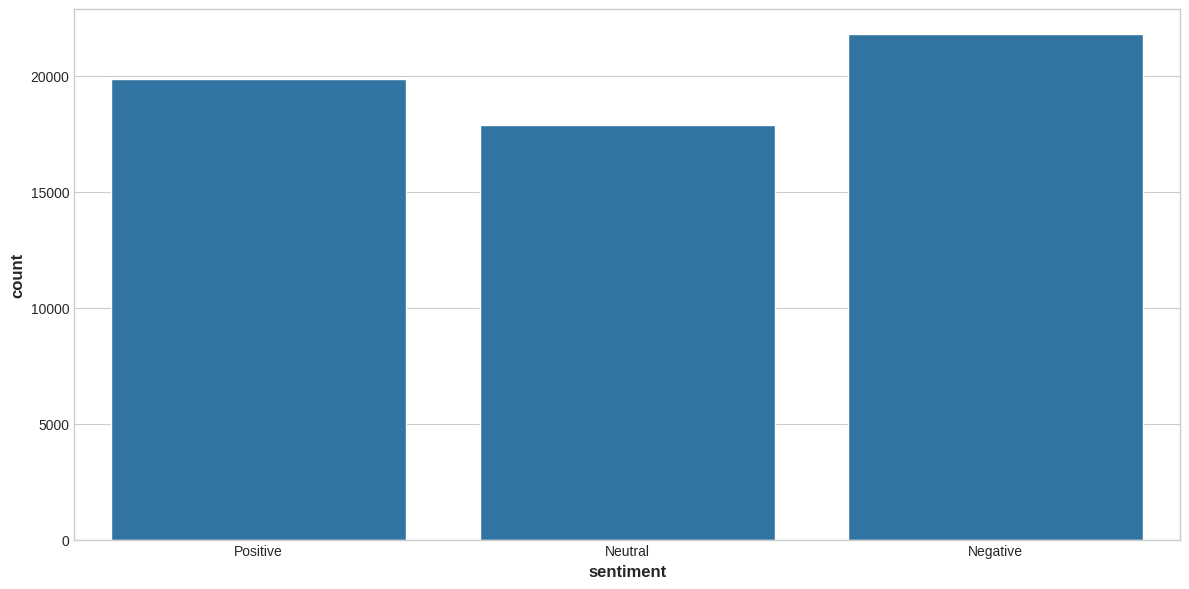

In [23]:
plt.figure(figsize = (12, 6))
sns.countplot(x='sentiment', data = data)

In [24]:
from plotly import graph_objs as go
# Create the funnel area chart
fig = go.Figure(go.Funnelarea(
    labels=temp.sentiment,  # Change from 'label' to 'labels'
    values=temp.content,      # This should be a numerical column
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))

# Show the figure
fig.show()

# Plotting Features

In [25]:
def plotting_sentiment(sentiment):
    word_cloud_sentiment = ''.join(data[data["sentiment"] == sentiment].content)

    #Creation of wordcloud
    wordcloud = WordCloud(
        max_font_size = 70,
        max_words=100,
        background_color="black",
        scale=10,
        width=1000,
        height=1000).generate(word_cloud_sentiment)
    print(wordcloud)
    #Figure properties
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

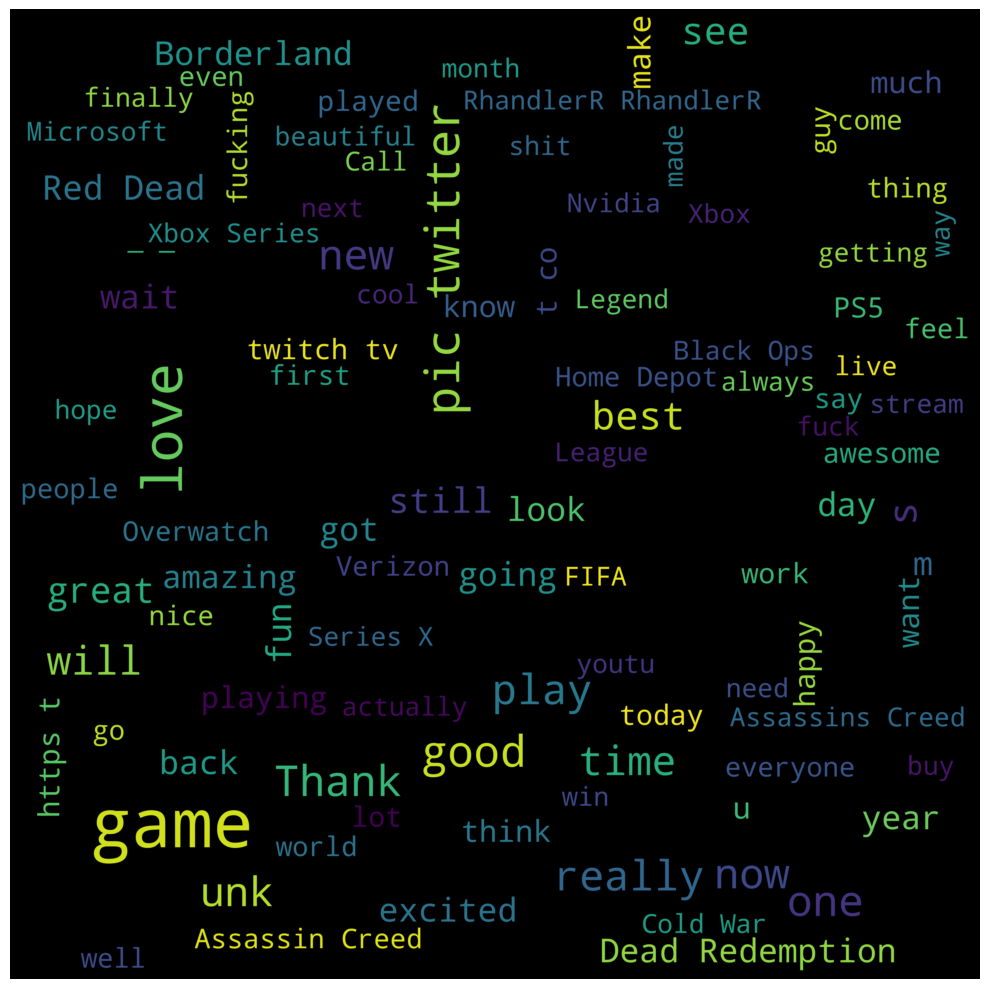

In [26]:
plotting_sentiment("Positive")

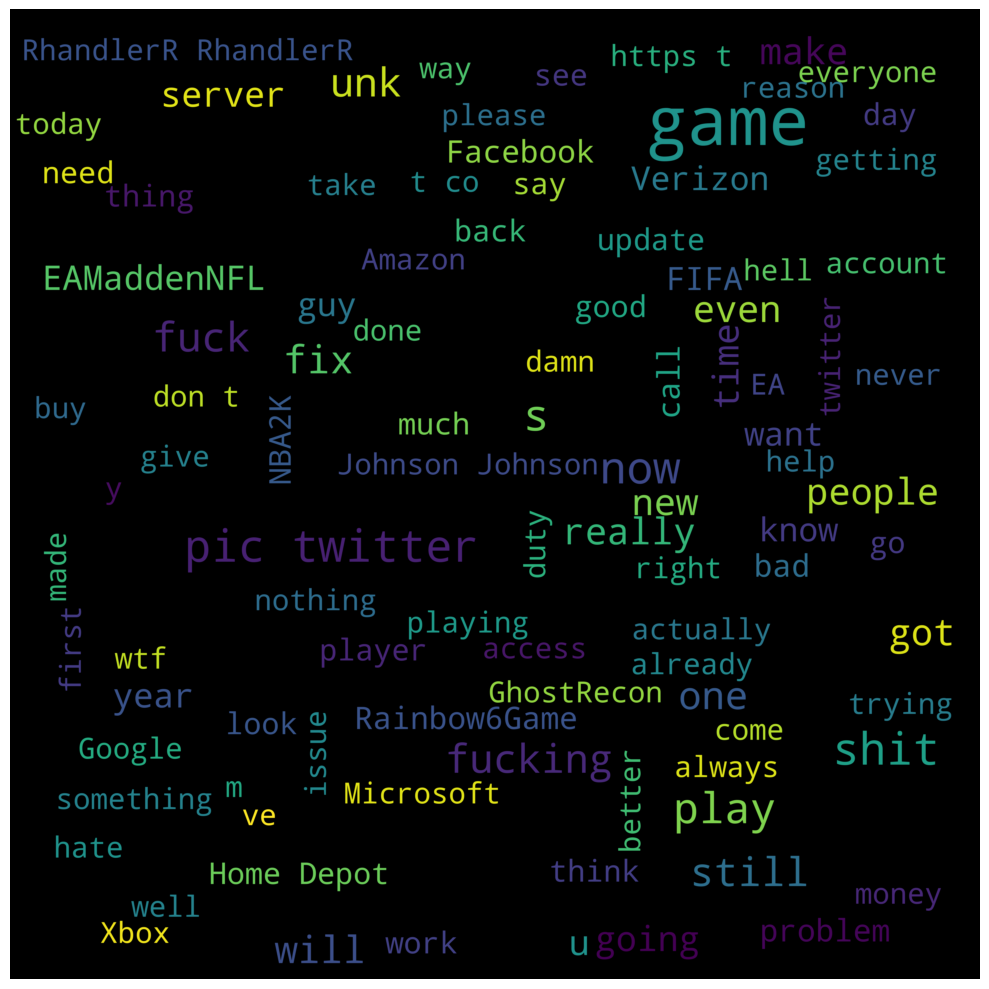

In [27]:
plotting_sentiment("Negative")

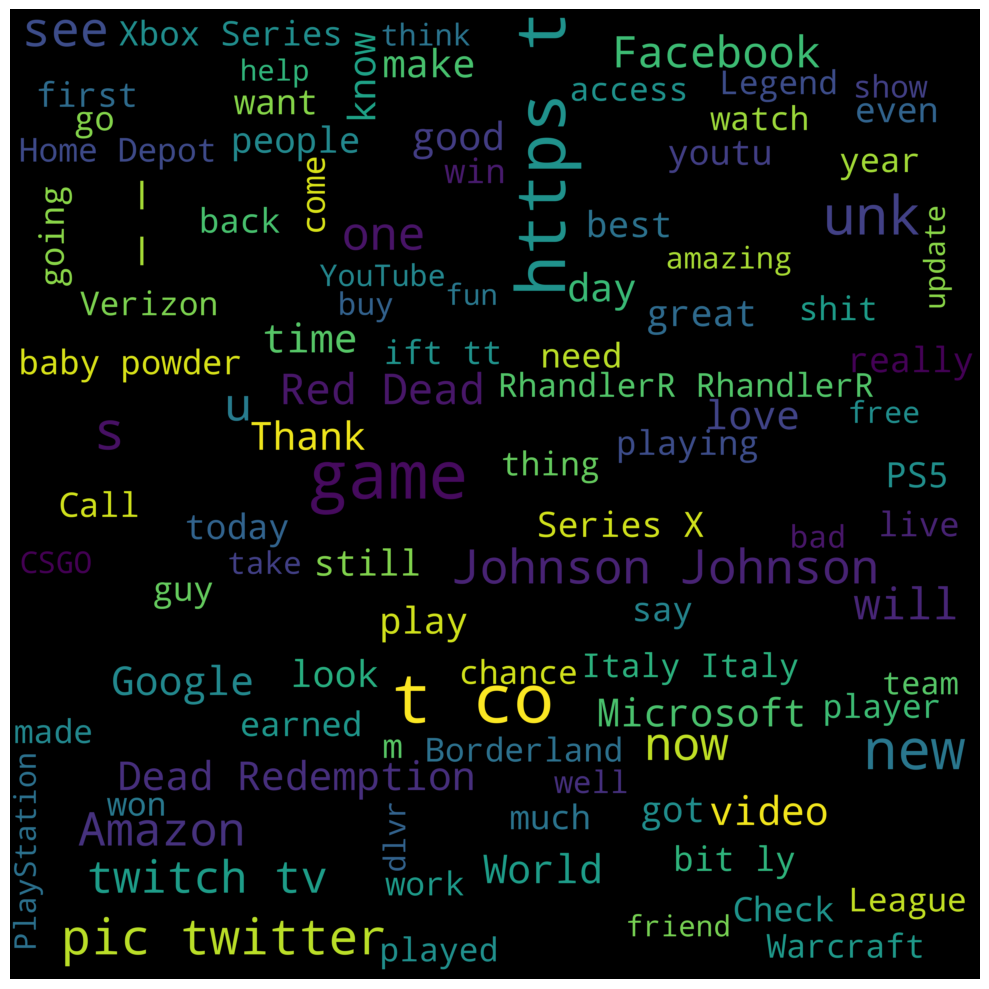

In [28]:
plotting_sentiment("Neutral")

In [29]:
plot_entity_sentiment=data.groupby(by=['entity', 'sentiment']).count().reset_index()
plot_entity_sentiment

,entity,sentiment,tweetid,content
0,Amazon,Negative,566,566
1,Amazon,Neutral,1210,1210
2,Amazon,Positive,306,306
3,ApexLegends,Negative,577,577
4,ApexLegends,Neutral,927,927
...,...,...,...,...
91,Xbox(Xseries),Neutral,405,405
92,Xbox(Xseries),Positive,746,746
93,johnson&johnson,Negative,818,818
94,johnson&johnson,Neutral,1010,1010


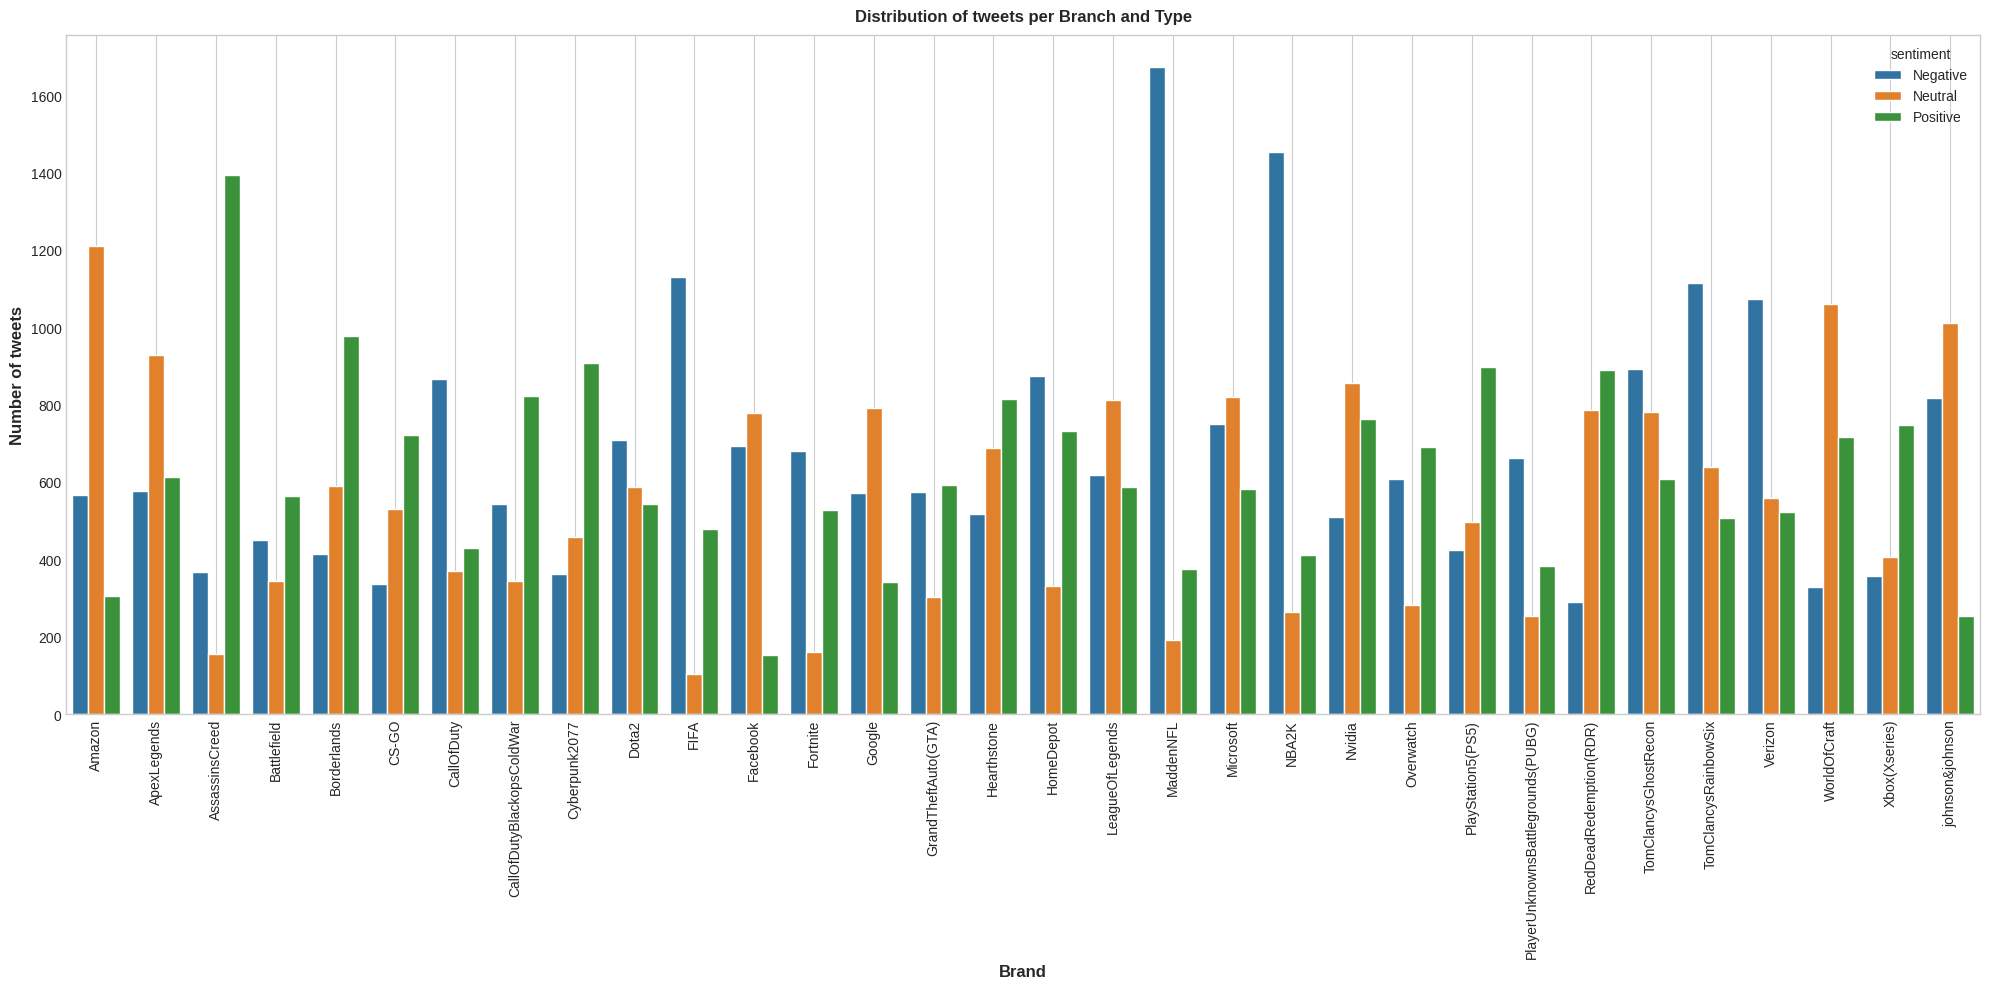

In [30]:
#Figure of comparison per branch

plt.figure(figsize=(20,10))
sns.barplot(data=plot_entity_sentiment,x="entity",y="tweetid",hue="sentiment")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type");

Text(9.444444444444462, 0.5, 'Entity')

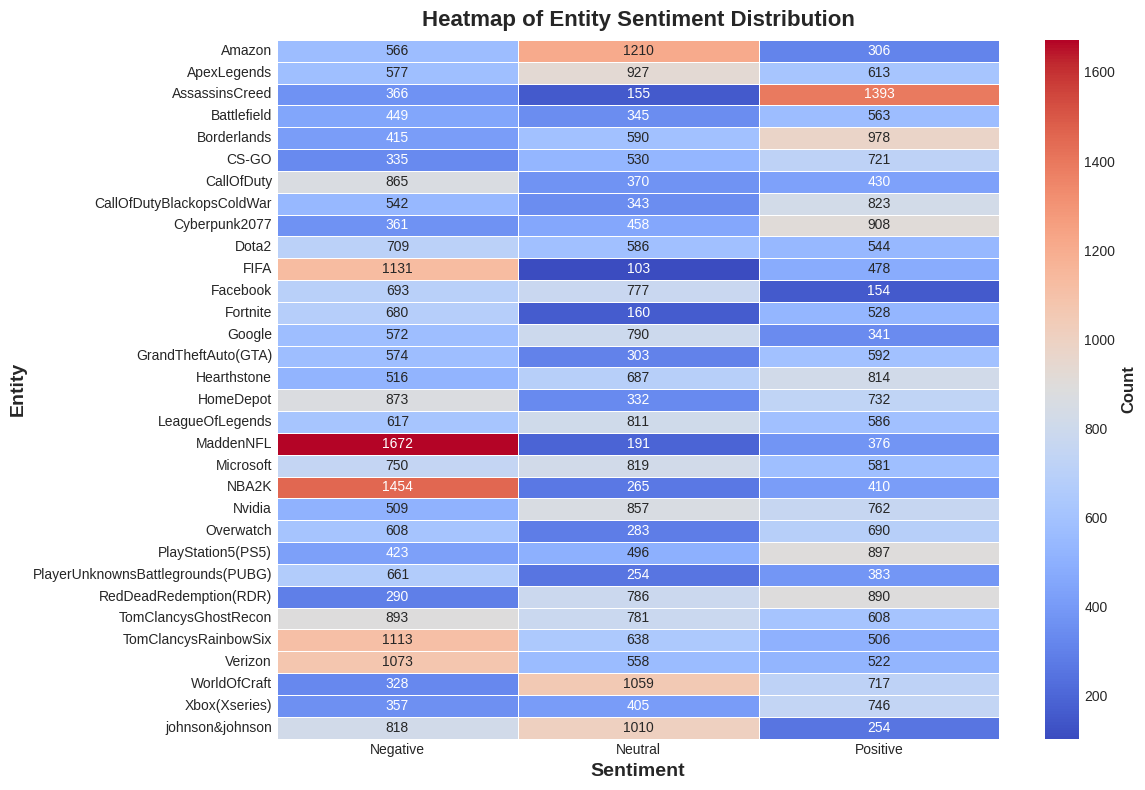

In [31]:
crosstab = pd.crosstab(index=df['entity'], columns=df['sentiment'])
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab, cmap='coolwarm', annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Count'})
plt.title('Heatmap of Entity Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Entity', fontsize=14)

In [32]:
data_onehot_encoding = pd.get_dummies(data, columns = ['entity', 'sentiment'], drop_first = True)
data_onehot_encoding

,tweetid,content,entity_ApexLegends,entity_AssassinsCreed,entity_Battlefield,entity_Borderlands,entity_CS-GO,entity_CallOfDuty,entity_CallOfDutyBlackopsColdWar,entity_Cyberpunk2077,...,entity_PlayerUnknownsBattlegrounds(PUBG),entity_RedDeadRedemption(RDR),entity_TomClancysGhostRecon,entity_TomClancysRainbowSix,entity_Verizon,entity_WorldOfCraft,entity_Xbox(Xseries),entity_johnson&johnson,sentiment_Neutral,sentiment_Positive
0,2401,im getting on borderlands and i will murder yo...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2401,I am coming to the borders and I will kill you...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2401,im getting on borderlands and i will kill you ...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2401,im coming on borderlands and i will murder you...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2401,im getting on borderlands 2 and i will murder ...,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,1373,I have noticed streamers I watch who are now p...,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
985,10588,@6th__man playing red dead redemption-\n\n“Oh ...,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
988,7516,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
989,5708,Thank you to Matching funds Home Depot RW paym...,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


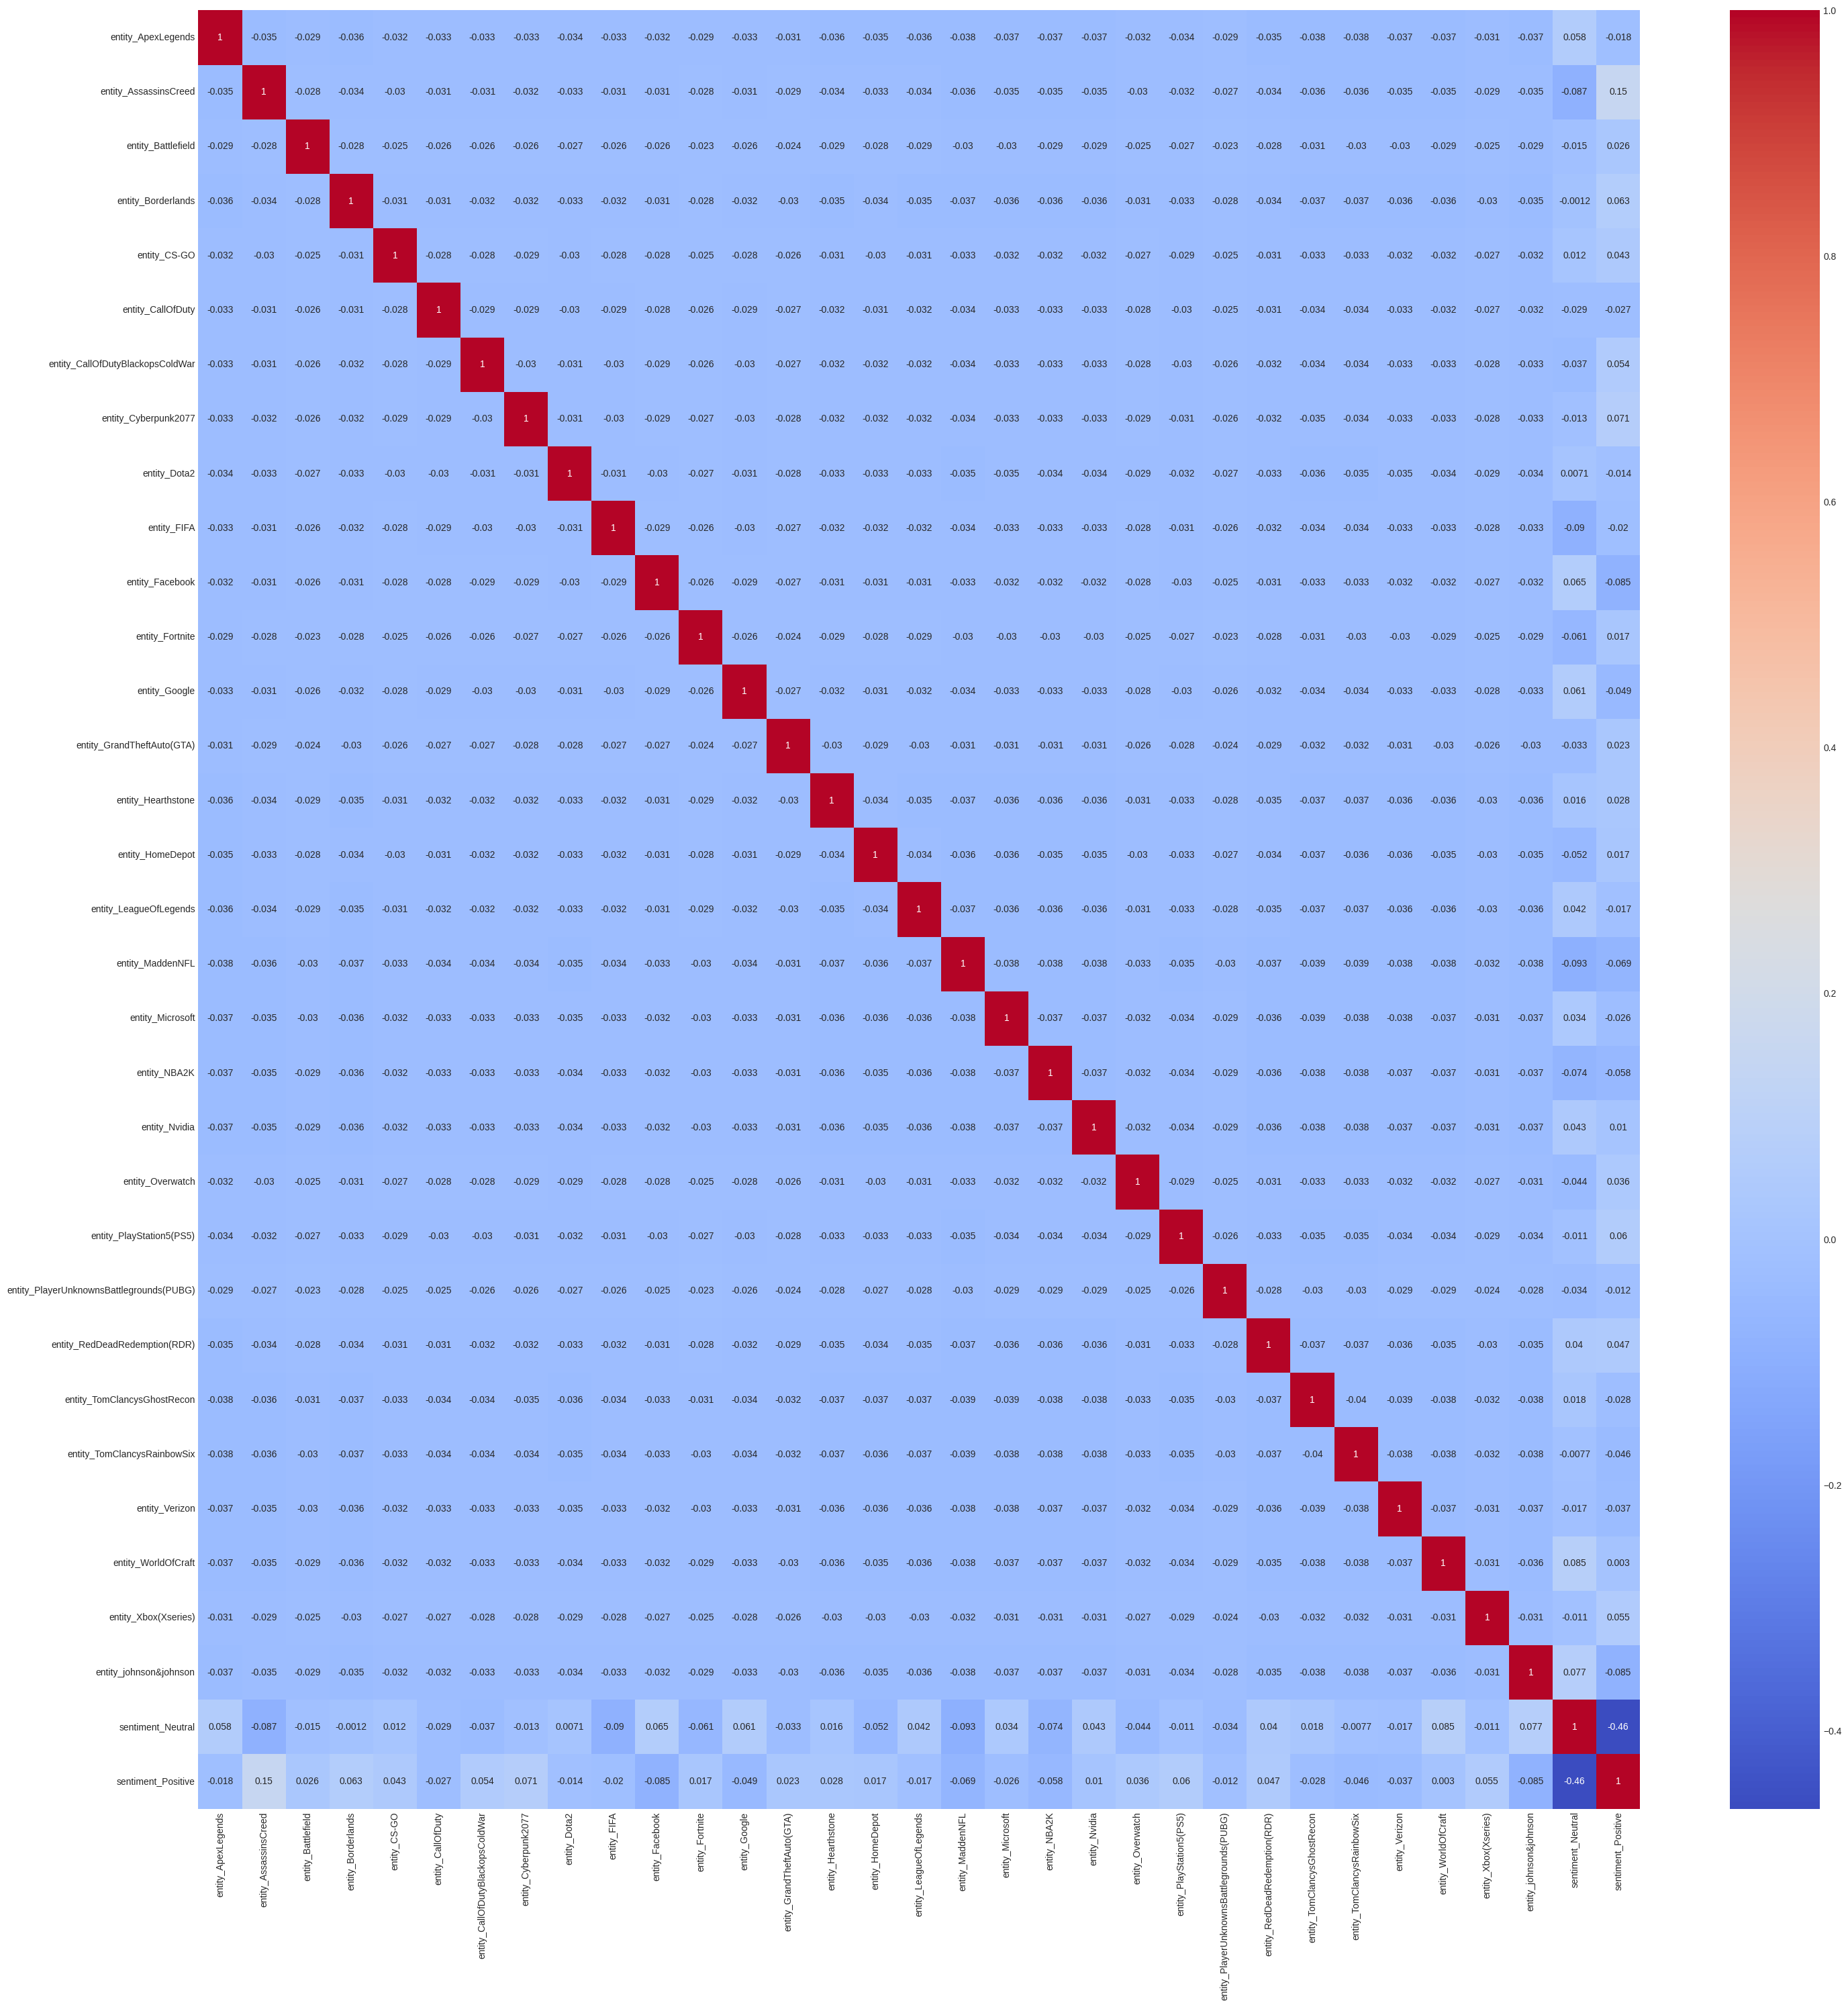

In [33]:
correlation = data_onehot_encoding.drop(columns = ['tweetid', 'content']).corr()
# Set the figure size
plt.figure(figsize=(30, 30))  # Width, Height in inches
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [34]:
#Text transformation

#lowercase
data["content"] = data.content.str.lower()

#converting all to string
data["content"] = [str(dt) for dt in data.content]

#regex
data["content"] = data.content.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))

In [35]:
data['sentiment'] = data['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

In [36]:
content_lens = []

for content in data.content:
    tweet_lens = len(content.split())
    content_lens.append(tweet_lens)

data['content_lens'] = content_lens


In [37]:
data

,tweetid,entity,sentiment,content,content_lens
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,10
1,2401,Borderlands,2,i am coming to the borders and i will kill you...,12
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12
...,...,...,...,...,...
984,1373,Battlefield,0,i have noticed streamers i watch who are now p...,44
985,10588,RedDeadRedemption(RDR),1,6th man playing red dead redemption oh shit a...,30
988,7516,LeagueOfLegends,1,suikoden 2 1 alex kidd in miracle world pe...,18
989,5708,HomeDepot,2,thank you to matching funds home depot rw paym...,25


<ipython-input-38-775c0158d67d>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




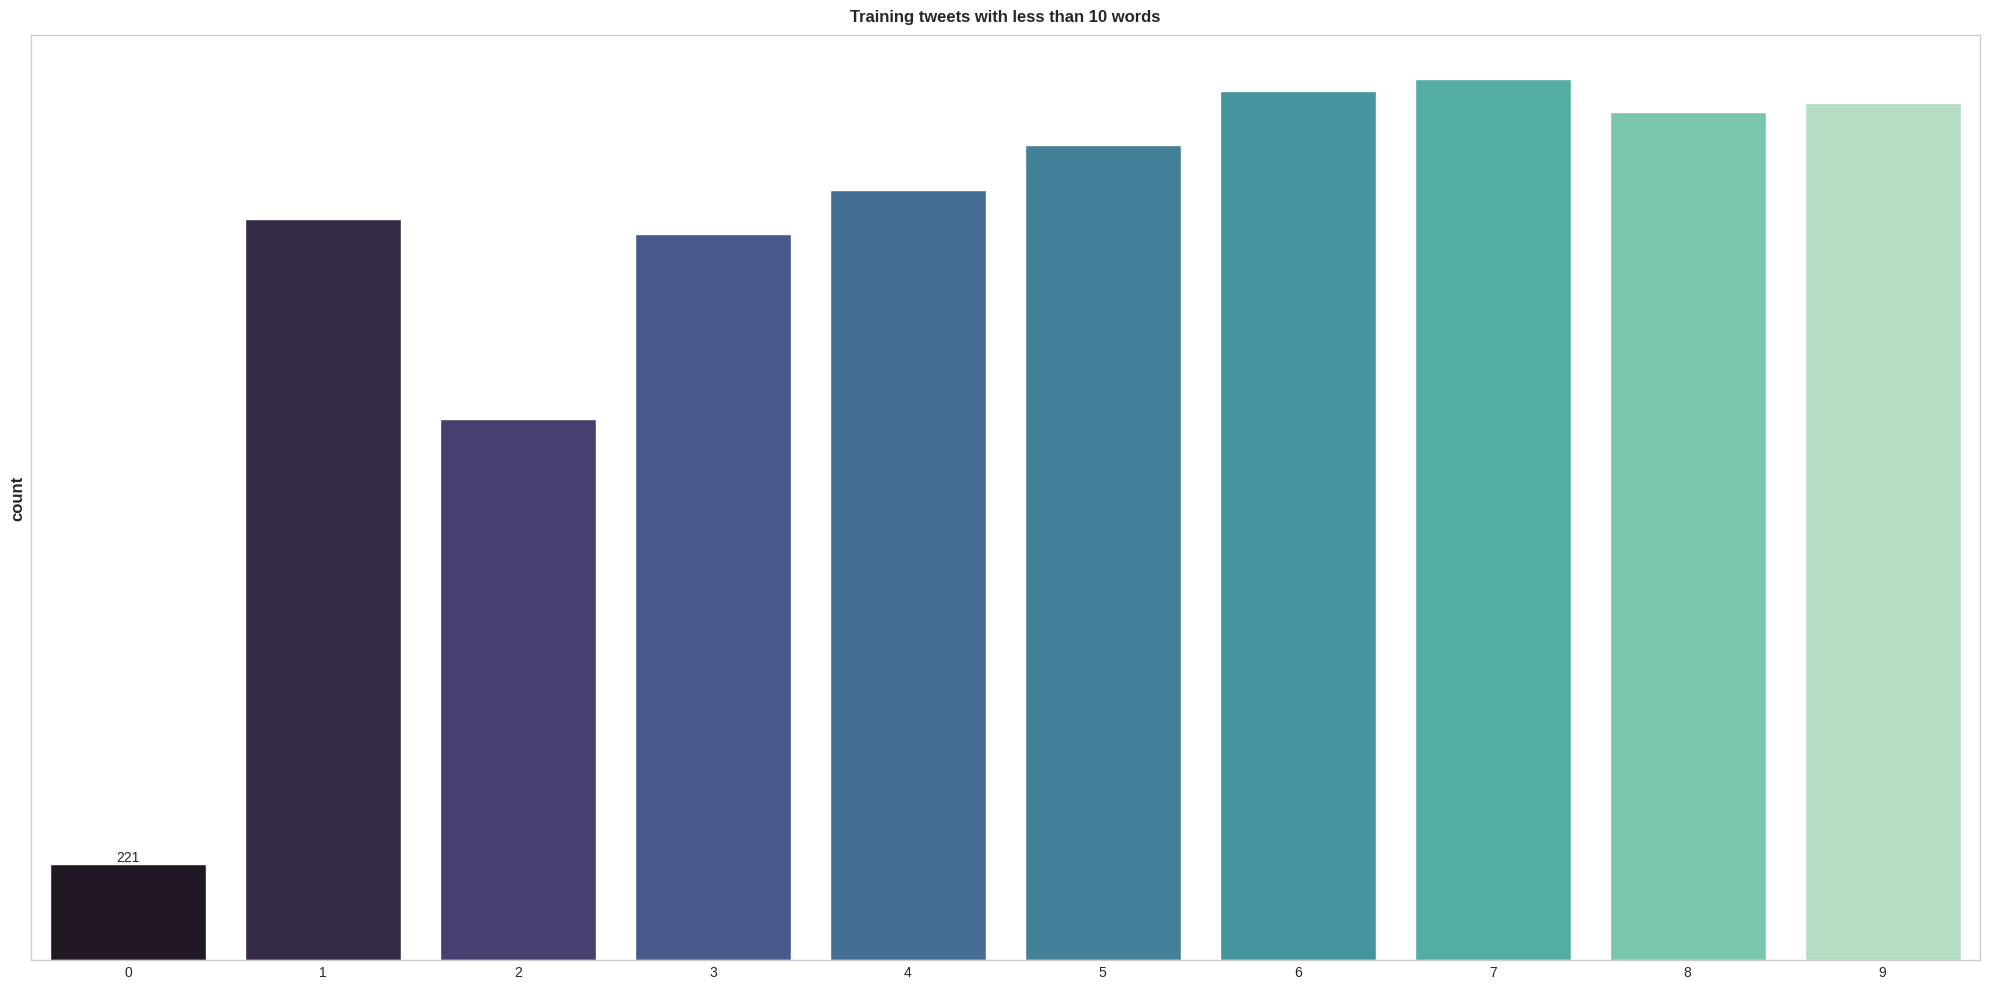

In [38]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='content_lens', data=data[data['content_lens']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [39]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
data.content_lens.max()

166

In [41]:
data = data [data['content_lens'] > 4]
data = data [data['content_lens'] < 105]

In [42]:
token_lens = []

for txt in data['content'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 132


In [43]:
# Thêm cột mới 'token_lens' vào DataFrame
data.loc[:, 'token_lens'] = token_lens

In [44]:
data

,tweetid,entity,sentiment,content,content_lens,token_lens
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...,10,13
1,2401,Borderlands,2,i am coming to the borders and i will kill you...,12,14
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...,10,13
3,2401,Borderlands,2,im coming on borderlands and i will murder you...,10,13
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...,12,15
...,...,...,...,...,...,...
984,1373,Battlefield,0,i have noticed streamers i watch who are now p...,44,48
985,10588,RedDeadRedemption(RDR),1,6th man playing red dead redemption oh shit a...,30,35
988,7516,LeagueOfLegends,1,suikoden 2 1 alex kidd in miracle world pe...,18,26
989,5708,HomeDepot,2,thank you to matching funds home depot rw paym...,25,35


In [45]:
data['sentiment'].value_counts()

sentiment
0    19435
2    17047
1    16394
Name: count, dtype: int64

# Class Balancing by RandomOverSampler

Train - Validation - Test split and onehot encoding

In [46]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(data['content']).reshape(-1, 1), np.array(data['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['content', 'sentiment']);

train_os['sentiment'].value_counts()


sentiment
2    19435
1    19435
0    19435
Name: count, dtype: int64

In [47]:
X = train_os['content'].values
y = train_os['sentiment'].values

X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, stratify=y,  test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, stratify=y_valid_test, test_size=0.5, random_state=42)

In [48]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [49]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 40813
VALIDATION DATA: 8746
TESTING DATA: 8746


In [50]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

# BERT Sentiment Analysis

In [51]:
MAX_LEN=150

def tokenize(data,max_length=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [52]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [53]:
from transformers import TFBertModel
bert = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
#keras
import tensorflow as tf
from tensorflow import keras

def create_model(bert, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [55]:
model = create_model(bert, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 150, 7                                           
                             68),                                                             

In [56]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

Epoch 1/4
1276/1276 [==============================] - 1382s 1s/step - loss: 0.5889 - categorical_accuracy: 0.7604 - val_loss: 0.3088 - val_categorical_accuracy: 0.8929
Epoch 2/4
1276/1276 [==============================] - 1317s 1s/step - loss: 0.2028 - categorical_accuracy: 0.9299 - val_loss: 0.2035 - val_categorical_accuracy: 0.9341
Epoch 3/4
1276/1276 [==============================] - 1317s 1s/step - loss: 0.0975 - categorical_accuracy: 0.9669 - val_loss: 0.1893 - val_categorical_accuracy: 0.9464
Epoch 4/4
1276/1276 [==============================] - 1263s 990ms/step - loss: 0.0865 - categorical_accuracy: 0.9714 - val_loss: 0.1798 - val_categorical_accuracy: 0.9482


# BERT results

In [57]:
result_bert = model.predict([test_input_ids,test_attention_masks])

274/274 [==============================] - 98s 327ms/step


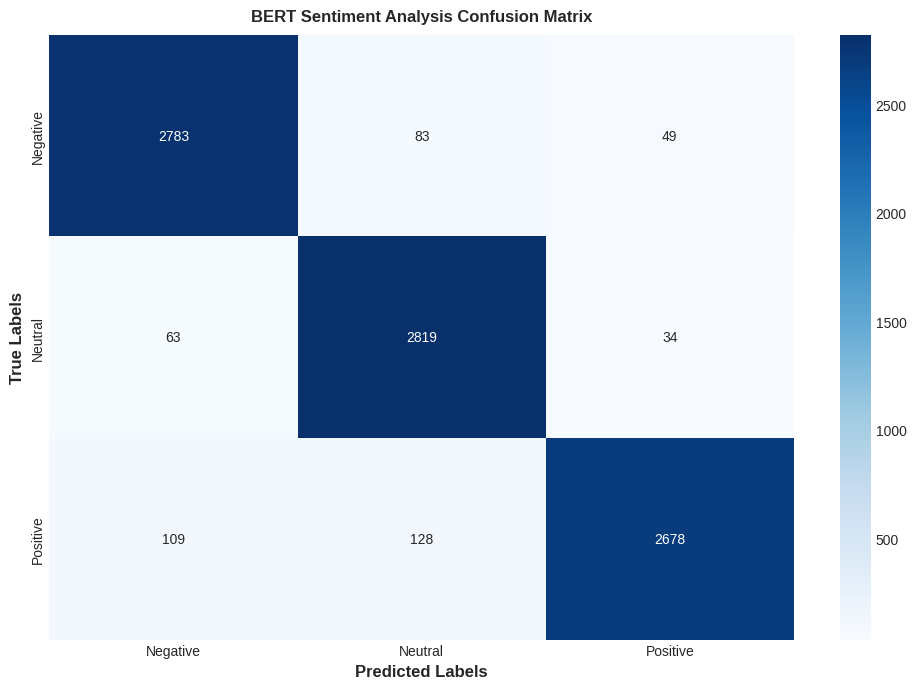

In [62]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1


# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))

# Vẽ biểu đồ heatmap cho ma trận nhầm lẫn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT Sentiment Analysis Confusion Matrix')
plt.show()

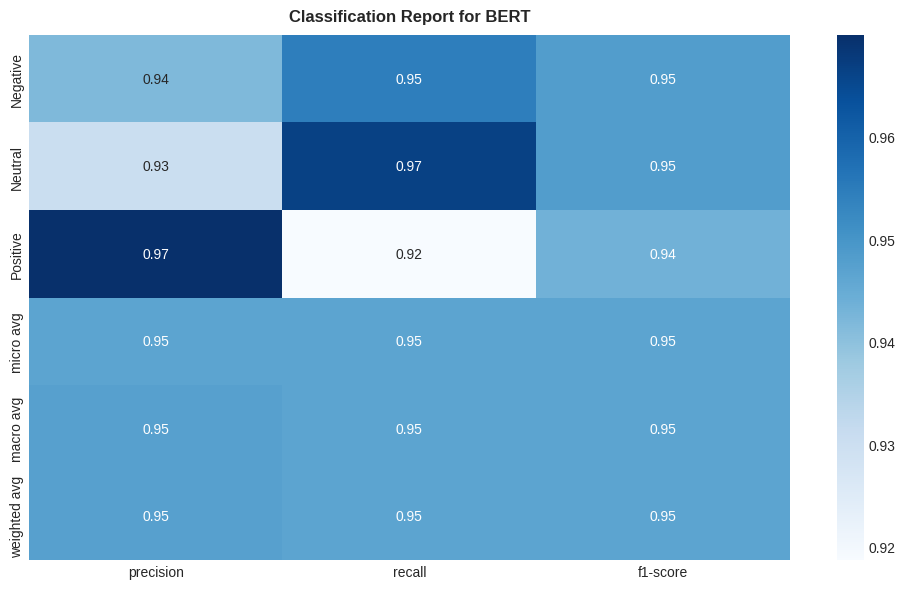

In [64]:
# Tạo báo cáo phân loại và chuyển đổi nó thành DataFrame
report = classification_report(y_test, y_pred_bert, target_names=['Negative', 'Neutral', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Vẽ heatmap sử dụng seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report for BERT')
plt.show()

In [63]:
# Lưu cấu trúc mô hình vào file JSON
model_json = model.to_json()
with open("bert_model.json", "w") as json_file:
    json_file.write(model_json)

# Lưu trọng số mô hình
model.save_weights("bert_model_weights.h5")

# Đọc cấu trúc mô hình từ file JSON
with open("bert_model.json", "r") as json_file:
    model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(model_json, custom_objects={"TFBertModel": TFBertModel})

# Tải lại trọng số mô hình
loaded_model.load_weights("bert_model_weights.h5")

In [65]:
result_bert = loaded_model.predict([test_input_ids,test_attention_masks])

274/274 [==============================] - 104s 332ms/step


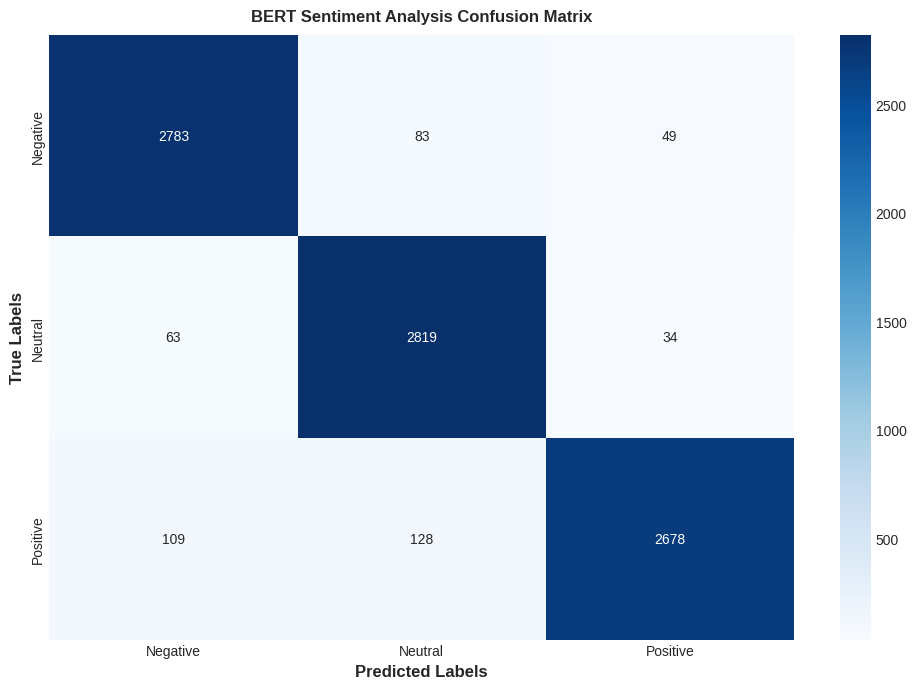

In [66]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1


# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))

# Vẽ biểu đồ heatmap cho ma trận nhầm lẫn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT Sentiment Analysis Confusion Matrix')
plt.show()